here I'm using a custom [scallop](https://github.com/Kingsford-Group/scallop) + [gtfmerge](https://github.com/Kingsford-Group/rnaseqtools#gtfmerge) pipeline to create merged gtf annotation of hg19 and tinat transcripts introduced in this 

Alex
> I was curious myself so I decided to align our RNA-seq data to their chimeric transcripts... it looks promising, but let me know if there's anything in my analysis I need to change. Still working on seeing if we can identify alternative TSS without CAGE-seq. 
I'm guessing we can look for novel transcripts using [StringTie](https://ccb.jhu.edu/software/stringtie/) or cufflinks?

Ray
> I'm asking because in [this paper](https://www.nature.com/articles/ng.3889) they treated lung cancer cells with decitabine and performed Cage-seq to map and identify cryptic transcription start sites. They found cryptic TSSs that generated spliced variants, half of which were in-frame isoforms (and some of which resulted in chimeric transcripts, others original or truncated). This got me thinking about our project and whether we could see these chimeric/fusion transcripts (that are skewed toward the 5'end due Cage-seq and being TSS-induced) in HL60s.  


Luke
> Hi Ray, Alex and Abe
This is an interesting paper which claims genetic alterations to DNA methylation core genes drive dysregulated hematopoietic development due to CpG changes that regulate transcription factor binding (figure 4 and 5). How many TFs are methylation sensitive has been controversial in my understanding but is an interesting idea with lots of data within mylomonocytic cells. https://www.nature.com/articles/s41588-020-0595-4
I am not suggesting a specific plan but this is an interesting idea.


In [2]:
cat ../hl60-exp/scallop/tinat/tinat-gtf-list.txt

hg19/hg19.knownGene.gtf
tinat/DAC+SB_TINATs.gtf
tinat/DAC_TINATs.gtf
tinat/SB939_TINATs.gtf



In [3]:
cat ../hl60-exp/scallop/tinat.sh

mkdir -p scallop/tinat/compare

PATH=$PATH:/rumi/shams/abe/Workflows/rnaseqtools-1.0.3/bin/

conda activate scallop
# 1. merge
gtfmerge union scallop/tinat/tinat-gtf-list.txt scallop/tinat/hg19.tinat.gtf -t 18
# 2. compare 
gffcompare -o scallop/tinat/gffall -r /rumi/shams/genomes/hg19/hg19_genes.gtf scallop/tinat/hg19.tinat.gtf 
# 3. subset
gtfcuff puniq scallop/tinat/gffall.hg19.tinat.gtf.tmap scallop/tinat/hg19.tinat.gtf /rumi/shams/genomes/hg19/hg19_genes.gtf scallop/tinat/unique.gtf
# 4. gtf2fasta
gffread scallop/tinat/unique.gtf -g /rumi/shams/genomes/hg19/hg19.fa -w scallop/tinat/unique.fa
# 5.concatenate with hg19 fasta
# mkdir -p scallop/hg19
# wget https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/genes/hg19.knownGene.gtf.gz
# mv hg19.knownGene.gtf.gz scallop/hg19/hg19.knownGene.gtf.gz
# gunzip scallop/hg19/hg19.knownGene.gtf.gz
gffread scallop/hg19/hg19.knownGene.gtf -g /rumi/shams/genomes/hg19/hg19.fa -w scallop/hg19/hg19.knownGene.fa
cat scallop/hg19/hg19.knownGene.f

Okay! I'm aligning these stuff to the same annotation!

In [4]:
cat salmon_tinat.sh

FASTQDIR=$1
OUTDIR=$2

INDEX=/rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-exp/scallop/tinat/salmon.index

mkdir -p $OUTDIR

for f in $FASTQDIR/*fastq.gz; do 
	samp=`basename ${f}`; 
	samp=${samp/.fastq.gz/}; 
	echo "Processing sample ${samp}"; 
	salmon quant -i $INDEX \
 	-l A -r $f -p 18 -o ${OUTDIR}/${samp}; 
done


In [5]:
# nohup bash salmon_tinat.sh \
# /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/other-fastq \
# /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/other-exp/hg19.tinat_quants > salmon_tinat.out


In [6]:
!mkdir -p scallop

# R

In [1]:
%reload_ext rpy2.ipython

In [7]:
%%R 
library (GenomicFeatures)
library (tximport)
library (tidyverse)
library (ggplot2)
library (ggrepel)
library (DESeq2)
library (patchwork)
library (BiocParallel)
register(MulticoreParam(4))

plot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}

### Load genome annotations 

In [8]:
%%R 
txdb.hg19  = makeTxDbFromGFF('../scallop-genome/hg19/hg19.knownGene.gtf', organism='Homo sapiens')

tin_1 <- rtracklayer::import('../scallop-genome/tinat/DAC+SB_TINATs.gtf')%>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tin_2 <- rtracklayer::import('../scallop-genome/tinat/DAC_TINATs.gtf')   %>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tin_3 <- rtracklayer::import('../scallop-genome/tinat/SB939_TINATs.gtf') %>% data.frame %>% filter(type == "transcript") %>% dplyr::select('gene_id','transcript_id')
tins <- rbind(tin_1, tin_2,tin_3) 
colnames(tins) <- c("GENEID", "TXNAME")
# tx2gene objects 
k.hg19 <- keys(txdb.hg19, keytype = "TXNAME")
tx2gene.hg19 <- AnnotationDbi::select(txdb.hg19, k.hg19, "GENEID", "TXNAME")

tx2gene = rbind(tx2gene.hg19, tins)

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK

R[write to console]: 'select()' returned 1:1 mapping between keys and columns



In [9]:
%%R
c(tin_1 %>% nrow, tin_2 %>% nrow, tin_3 %>% nrow)

[1] 3627  453  744


Read salmon quants 

In [11]:
%%R
files <- list.files(path='hg19.tinat_quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("hg19.tinat_quants/(\\S+)/quant.sf","\\1",files)

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=T)

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 7 
R[write to console]: 8 
R[write to console]: 9 
R[write to console]: 10 
R[write to console]: 11 
R[write to console]: 12 
R[write to console]: 13 
R[write to console]: 14 
R[write to console]: 15 
R[write to console]: 16 
R[write to console]: 17 
R[write to console]: 18 
R[write to console]: 19 
R[write to console]: 20 
R[write to console]: 21 
R[write to console]: 22 
R[write to console]: 23 
R[write to console]: 24 
R[write to console]: 25 
R[write to console]: 26 
R[write to console]: 27 
R[write to console]: 28 
R[write to console]: 29 
R[write to console]: 30 
R[write to console]: 



In [ ]:
# %%R
# txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

Define the sample sheet 

In [12]:
%%R 
# meta 
lines   <- lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist 
treats  <- rep(c(rep('treated',3), rep('DMSO',3)),5)
reps    <- rep(c('rep1','rep2','rep3'),5)

colData <- data.frame(
    line=lines, 
    cond=treats, 
    sample_id=paste(lines, treats, reps, sep='_'), 
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData$cond <- factor(colData$cond)

summary(colData)

     line                cond     sample_id        
 Length:30          DMSO   :15   Length:30         
 Class :character   treated:15   Class :character  
 Mode  :character                Mode  :character  


In [13]:
%%R 
dds0 <- DESeqDataSetFromTximport(txi, colData, ~ line + cond)
dds0$cond = relevel(dds0$cond, ref='DMSO')
nrow(dds0)

R[write to console]: using counts and average transcript lengths from tximport



[1] 35932


In [20]:
%%R
# save normazlied counts 
dds0 <- estimateSizeFactors(dds0)
ncu <- counts(dds0, normalized=TRUE)
write.table(
    ncu[!rownames(ncu) %in% tx2gene.hg19$TXNAME,],
    'other_tinat_exp_deseq2_norm.txt',sep="\t", quote=FALSE, col.names=colData$sample_id)

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size



# Differential expression analysis

In [23]:
%%R

# Filter non-informative genes:
filter_low_counts <- function (dds_in , min_count=10){
    # all samples with a count of higher than `min_count`
    keep <- rowSums(counts(dds_in ) > min_count) == ncol(dds_in )
    # at least 3 samples with a count of 10 or higher
    # keep <- rowSums(counts(dds) >= 10) >= 3

    dds_out <- dds_in [keep,]
    print (paste (nrow(dds_in), 'genes filtered to ->' , nrow(dds_out),'genes!', sep=' ') )
    return (dds_out)
}


plot_PCA <- function(vsd, colData, gr=c('cond'), title='', leg="none"){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(size = 2,  color=group), alpha = 4/10) +
            geom_text_repel(aes(label = row.names(colData)),size = 3.5) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides (size = FALSE) +
            ggtitle (title)+ 
            theme(legend.position=leg)
    return (pca)
}

plot_Volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title='', x_min=-20,x_max=20){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            xlim(c(x_min,x_max)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:7,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
     return (vol)
} 

get_Result <- function(dds, design){
    res = results(dds, contrast=design, parallel=TRUE)  %>% data.frame  %>% add_column(name=rownames(dds))
    res$log2FoldChange[is.na(res$log2FoldChange)] <- 0
    res$padj[is.na(res$padj)] <- 1
    return (res)
}

write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}

In [24]:
%%R 
dds1 <- DESeqDataSetFromTximport(txi, colData, ~cond)

DDS = list()
VSD = list()
RES = list()

# for loop to split DESeq object for more stable analysis  
for (l in unique(colData$line) ){
    k = colData$line == l
    DDS[[l]] <- dds1[,c(k)] # subset samples from dds object https://www.biostars.org/p/442188/
    # for Differential Expression
    DDS[[l]] = DESeq(DDS[[l]]) #, parallel=TRUE)
    RES[[l]] = get_Result(DDS[[l]])
    # for PCA 
    VSD[[l]] <- varianceStabilizingTransformation(filter_low_counts(DDS[[l]]))
    print (l)
}

R[write to console]: using counts and average transcript lengths from tximport



[1] "kg1"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "35932 genes filtered to -> 6420 genes!"
[1] "molm14"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "35932 genes filtered to -> 5024 genes!"
[1] "ociaml2"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "35932 genes filtered to -> 5564 genes!"
[1] "ociaml3"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "35932 genes filtered to -> 5910 genes!"
[1] "thp1"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "35932 genes filtered to -> 6188 genes!"


In [27]:
%%R 
# for loop fails!!! 
kg1 <- plot_PCA(
    VSD[["kg1"]], 
    colData[colData$line == "kg1",], 
    title = 'cell line: kg1'
) 

molm14 <- plot_PCA(
    VSD[["molm14"]], 
    colData[colData$line == "molm14",], 
    title = 'cell line: molm14'
)

thp1 <- plot_PCA(
    VSD[["thp1"]], #[,c(rownames(colData[colData$line == "thp1",])!='thp1_u_2')], 
    colData[colData$line == "thp1",],# & rownames(colData)!='thp1_u_2',], 
    title = 'cell line: thp1'
)

ociaml2 <- plot_PCA(
    VSD[["ociaml2"]], #[,c(rownames(colData[colData$line == "ociaml2",])!='ociaml2_u_2')],
    colData[colData$line == "ociaml2",],# & rownames(colData)!='ociaml2_u_2',], 
    title = 'cell line: ociaml2'
)

ociaml3 <- plot_PCA(
    VSD[["ociaml3"]], 
    colData[colData$line == "ociaml3",], 
    title = 'cell line: ociaml3'
)

In [29]:
%%R 
p1 = kg1 / molm14 / thp1
p2 = ociaml2 / ociaml3

#start pdf
pdf('PCA_split_cell_lines.pdf')
print (p1)
print (p2)
#end pdf
dev.off()


png 
  2 


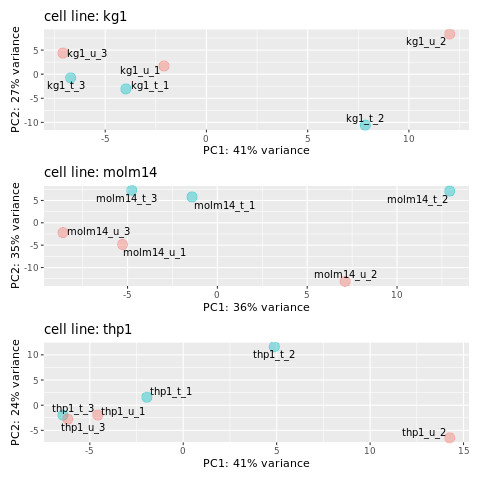

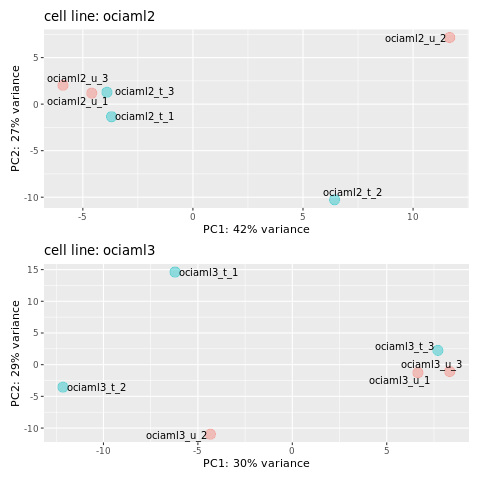

In [30]:
%%R 
print (p1)
print (p2)


Volcano plots:

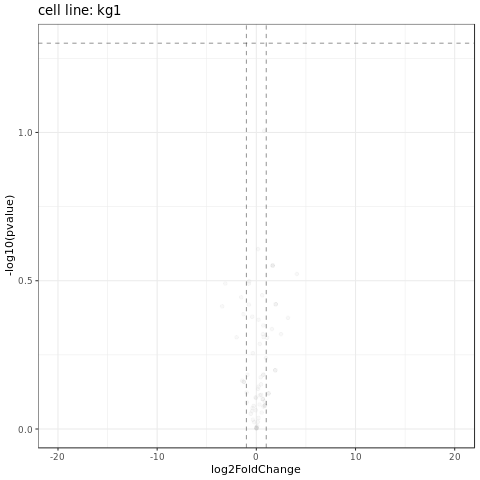

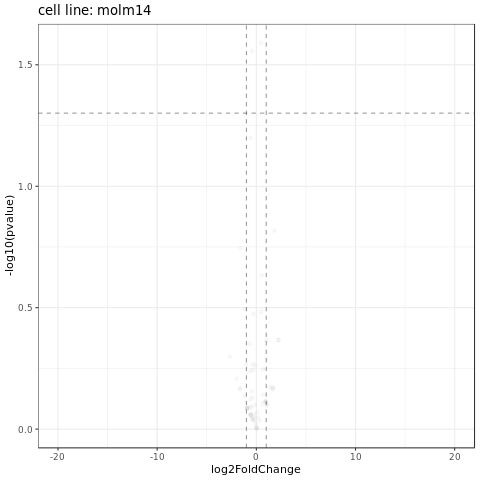

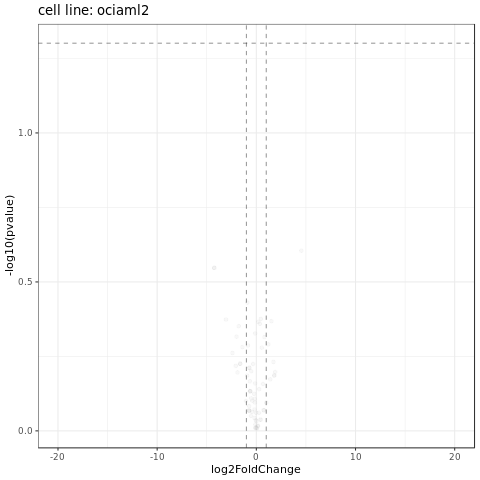

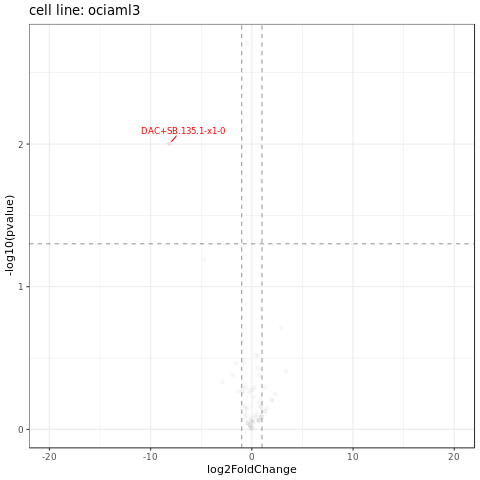

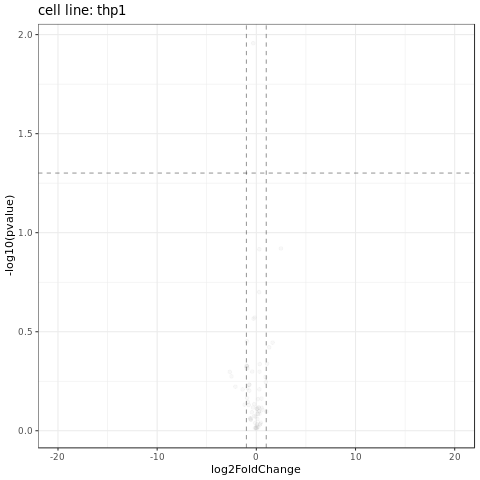

In [32]:
%%R 

for (line in  names(RES)){
    print (plot_Volcano(RES[[line]][tins$GENEID,], title = paste('cell line:', line) ) )
}
# pdf('Volcano_plots.pdf')
# dev.off()

In [35]:
%%R    
for (line in names(RES) ){ 

    df = RES[[line]] %>% data.frame

    write_Result(
        df[
            !rownames(dds0) %in% tx2gene.hg19$TXNAME,
            c('name','baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue','padj')],
        
        paste(line,'_tinat_delta_exp_table','.txt',sep=''),row=TRUE,col=TRUE)
}

## Clustering 

In [1]:
# %reload_ext rpy2.ipython

In [24]:
# import pandas as pd 
# df = pd.read_table('scallop/results_time_factor.txt')
# ncu = pd.read_table('scallop/DE2norm.txt')

In [64]:
# %%R -i df,ncu
# library (tidyverse)
# library(RColorBrewer)
# library(pheatmap)

# df_sig = df %>% 
#     filter (pval_6h< 0.001 | pval_72h< 0.001 | pval_120h< 0.001) %>% 
#     remove_rownames %>% column_to_rownames('gene_id') 


# # Subset normalized counts to significant genes
# sig_norm_counts <- ncu[rownames(df_sig), ]

# # Choose heatmap color palette
# heat_colors <- brewer.pal(n = 6, name = "YlOrRd")

# ann_colors = list(
#     cond = c('DMSO'="blue", 'treated'="firebrick"),
#     time = c('120h'= "darkgreen", '72h'="red", '6h'="orange")
# )

# colnames(sig_norm_counts) = rownames(colData)

# # Plot heatmap
# h = pheatmap(sig_norm_counts, 
#          color = heat_colors, 
#          cluster_cols = T, 
#          cluster_rows = T, 
#          show_rownames = F,
#          annotation = dplyr::select(colData, time, cond), 
#          scale = 'row', 
#          angle_col= 45,
# #          fontsize_row = 2,
#          annotation_legend=F,
#          annotation_colors = ann_colors)

In [65]:
# %%R 
# # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# pdf('scallop/Heatmap_clustering.pdf', width=7, height=7)
# grid::grid.newpage()
# grid::grid.draw(h$gtable)
# dev.off()

In [66]:
%%R 
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] patchwork_1.0.0             DESeq2_1.20.0              
 [3] SummarizedExperiment_1.10.1 DelayedArray_0.6.6         
 [5] BiocParallel_1.14.2         matrixStats_0.55.0         
 [7] ggrepel_0.8.1               forcats_0.4.0              
 [9] stringr_1.4.0    